# Setup

In [10]:
import numpy as np
np.random.seed(0)
import math
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import torch
torch.manual_seed(0)
import torchvision
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#Check if CUDA is available and get the CUDA device name
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Using cuda device
NVIDIA GeForce GTX 1660 Ti


# Load MNIST

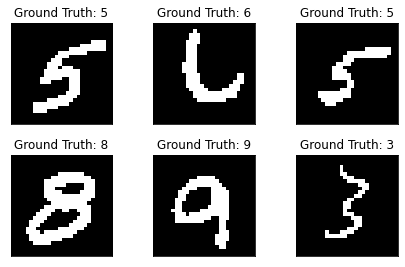

In [11]:
#Binary custom transform to convert MNIST to 1-bit images
class BinaryTransform:
    def __call__(self, x):
        x[x >= 0.5] = 1
        x[x < 0.5] = 0
        return x
    
# Load datasets into a loader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)
    
batch_size = 64
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(), BinaryTransform()
                             ])),
  batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(), BinaryTransform()
                             ])),
  batch_size=64, shuffle=True, worker_init_fn=seed_worker, generator=g)

# View some examples of the dataset
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

# Define the CNN

In [14]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        #print(x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        #print(x.shape)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
input_size  = 28*28   # images are 28x28 pixels
n_features = 6        # number of feature maps
output_size = 10      # there are 10 classes        

#Net1 = free weights
net1 = CNN(input_size, n_features, output_size); net1.to(device); print(net1)
optimizer1 = optim.Adam(net1.parameters(), lr=0.001)

#Only Conv layers weights are positive
net2 = CNN(input_size, n_features, output_size); net2.to(device)
optimizer2 = optim.Adam(net2.parameters(), lr=0.001)

#All weights are positive
net3 = CNN(input_size, n_features, output_size); net3.to(device)
optimizer3 = optim.Adam(net3.parameters(), lr=0.001)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


# Train the CNN

In [15]:
# Define training and test and confusion functions
def train(model, optimizer, train_loader, test_loader, epochs, clamped = 0):  
    acc = np.zeros(epochs) #accuracy vector with epochs
    # Train loop
    model.train()
    indx_epoch = 1
    for epoch in range(epochs): 
        indx_batch = 1
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            model.zero_grad()  
            output = model(x) 
            loss_value = nn.NLLLoss()(output, y)
            loss_value.backward()
            optimizer.step()
            if clamped == 1: #Only clamp conv layers
                for p in model.conv1.parameters():
                    p.data.clamp_(0)
                    
                for p in model.conv2.parameters():
                    p.data.clamp_(0)   
                    
            elif clamped == 2: #Clamp all layers
                for p in model.parameters():
                    p.data.clamp_(0)
            
            print('Batch: {}/{}, Running Loss = {}'.format(indx_batch, len(train_loader), loss_value.item()), end="\r") 
            indx_batch = indx_batch + 1
        print('Epoch: {}/{}, Latest training loss = {}'.format(indx_epoch, epochs, loss_value))
        acc_current, y_true, y_pred = test(model, test_loader = test_loader)
        indx_epoch = indx_epoch + 1
        acc[epoch] = acc_current
    return acc
        
def test(model, test_loader, noise_conv = 0, noise_fc = 0):
    # Settings
    y_pred = []
    y_true = []
    model.eval()
    correct = 0
    
    def add_noise(w, noise_variance_multiplier):
        noise_var = noise_variance_multiplier*w
        noise_w = (noise_var**0.5)*torch.randn(list(w.size())).to(device)
        return w + noise_w

    # Test data
    
    #Keep a copy of model weights
    if noise_conv == 1 or noise_fc == 1:
        model_conv1 = torch.clone(model.conv1.weight)
        model_conv2 = torch.clone(model.conv2.weight)
        model_fc1 = torch.clone(model.fc1.weight)
        model_fc2 = torch.clone(model.fc2.weight)
    
    with torch.no_grad():
        for data in test_loader:
            #Unpack test pairs then predict
            x, y = data
            x = x.to(device)
            y = y.to(device)
            
            if noise_conv == 1: #Apply noise to conv_layers
                model.conv1.weight = nn.Parameter(add_noise(model_conv1, 0.004))
                model.conv2.weight = nn.Parameter(add_noise(model_conv2, 0.004))
                
            if noise_fc == 1: #Apply noise to FC layers
                model.fc1.weight = nn.Parameter(add_noise(model_fc1, 0.004))
                model.fc2.weight = nn.Parameter(add_noise(model_fc2, 0.004))
        
            output = torch.argmax(model(x), dim = 1)
            correct = correct + (output == y).sum()
            
            #Save the true and predicted values to plot confusion matrix later
            y = y.cpu().numpy() #Save Truth
            y_true.extend(y) 
            output = output.cpu().numpy() #Save Prediction
            y_pred.extend(output) 
    
    #Reset the weights, in case you applied noise
    if noise_conv == 1 or noise_fc == 1:
        model.conv1.weight = nn.Parameter(model_conv1)
        model.conv2.weight = nn.Parameter(model_conv2)
        model.fc1.weight = nn.Parameter(model_fc1)
        model.fc2.weight = nn.Parameter(model_fc2)
    
    print(f"Test Accuracy = {correct / len(test_loader.dataset)}\n")
    return correct / len(test_loader.dataset), y_true, y_pred

def confusion(y_true, y_pred):
    #Class labels
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

    #Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix, axis = 0), index = [i for i in classes], columns = [i for i in classes])
    
    #Plot confusion matrix
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt = '0.4f')
    plt.xlabel('True numbers')
    plt.ylabel('Predicted numbers')

#Train a network with free weights
epochs = 15
print('#######Training network with free kernel weights##########')
acc_free = train(model = net1, optimizer = optimizer1, train_loader = train_loader, test_loader = test_loader, epochs = epochs, clamped = 0)

#Train a network with positive weights for conv layers
print('#######Training network with positive weights for conv layers##########')
acc_clamped_conv = train(model = net2, optimizer = optimizer2, train_loader = train_loader, test_loader = test_loader, epochs = epochs, clamped = 1)

#Train a network with positive weights for all layers 
print('#######Training network with positive weights for all layers##########')
acc_clamped = train(model = net3, optimizer = optimizer3, train_loader = train_loader, test_loader = test_loader, epochs = epochs, clamped = 2)

#######Training network with free kernel weights##########
Epoch: 1/15, Latest training loss = 0.41313984990119934
Test Accuracy = 0.9350999593734741

Epoch: 2/15, Latest training loss = 0.0997597947716713
Test Accuracy = 0.9580999612808228

Epoch: 3/15, Latest training loss = 0.036235593259334564
Test Accuracy = 0.9718999862670898

Epoch: 4/15, Latest training loss = 0.057103488594293594
Test Accuracy = 0.9750999808311462

Epoch: 5/15, Latest training loss = 0.21407471597194672
Test Accuracy = 0.979699969291687

Epoch: 6/15, Latest training loss = 0.06219358742237091
Test Accuracy = 0.9801999926567078

Epoch: 7/15, Latest training loss = 0.04224343225359917
Test Accuracy = 0.9813999533653259

Epoch: 8/15, Latest training loss = 0.003551369532942772
Test Accuracy = 0.9837999939918518

Epoch: 9/15, Latest training loss = 0.008323987014591694
Test Accuracy = 0.9810999631881714

Epoch: 10/15, Latest training loss = 0.0593612939119339
Test Accuracy = 0.9830999970436096

Epoch: 11/15, Lates

Text(0, 0.5, 'Testing accuracy (%)')

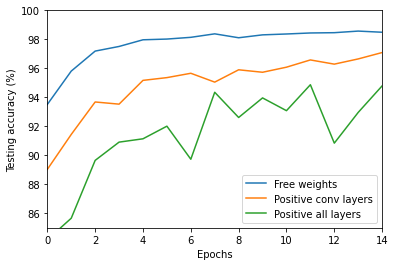

In [16]:
# save models
torch.save(net1, 'net1')
torch.save(net2, 'net2')
torch.save(net3, 'net3')

# plot
plt.plot(np.arange(epochs), 100*(acc_free), label='Free weights')
plt.plot(np.arange(epochs), 100*(acc_clamped_conv), label='Positive conv layers')
plt.plot(np.arange(epochs), 100*(acc_clamped), label='Positive all layers')
plt.xlabel('Epochs')
plt.xlim(0, epochs-1)
plt.ylim(85, 100)
plt.legend(loc = 'best')
plt.ylabel('Testing accuracy (%)')

# Test the CNN on GPU (32-bits)

Inference accuracy with GPU 32-bit accuracy and free weights
Test Accuracy = 0.9848999977111816

Inference accuracy with GPU 32-bit accuracy and positive only weights for conv layers
Test Accuracy = 0.9708999991416931

Inference accuracy with GPU 32-bit accuracy and positive only weights for all layers
Test Accuracy = 0.9478999972343445



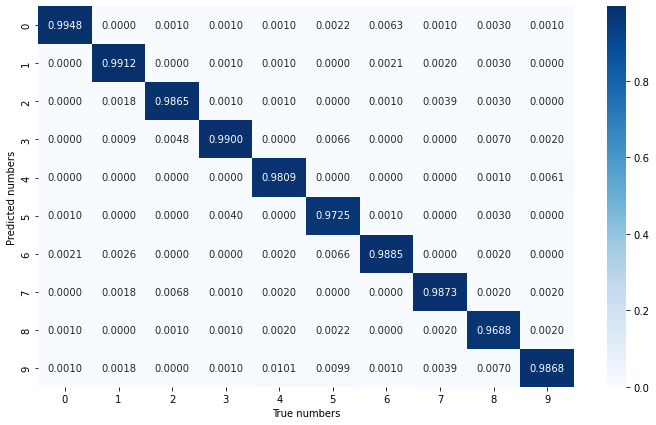

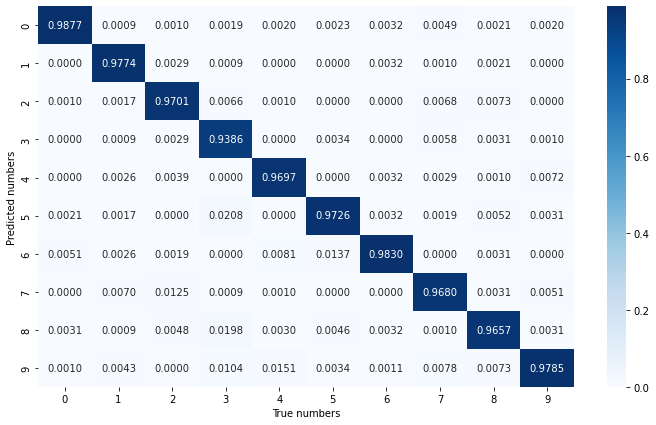

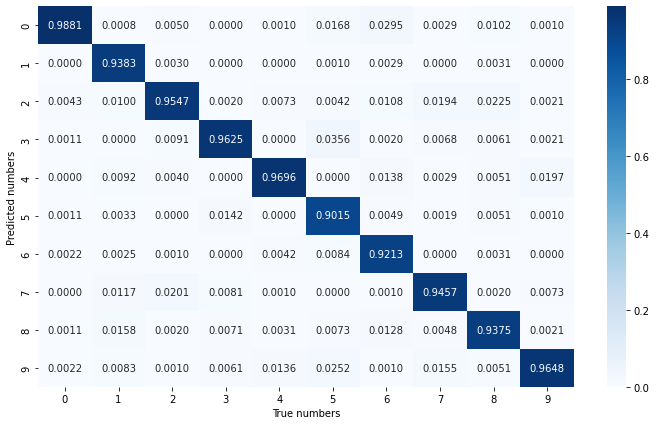

In [17]:
#Print weights 
#print(net2.conv1.weight)
#print(net2.conv2.weight)
#print(net2.fc1.weight)
#print(net2.fc2.weight)

#Test
print("Inference accuracy with GPU 32-bit accuracy and free weights")
acc_GPU, y_true, y_pred = test(model = net1, test_loader = test_loader) #Free weights
confusion(y_true, y_pred)
print("Inference accuracy with GPU 32-bit accuracy and positive only weights for conv layers")
acc, y_true, y_pred = test(model = net2, test_loader = test_loader) #Clamped weights for conv layer
confusion(y_true, y_pred)
print("Inference accuracy with GPU 32-bit accuracy and positive only weights for all layers")
acc, y_true, y_pred = test(model = net3, test_loader = test_loader) #Clamped weights for all layers
confusion(y_true, y_pred)

# Upload Conv layers on PTC (4-bits) and test

Inference accuracy with PCM 4-bit accuracy + only Conv layers on PCM
Test Accuracy = 0.9695000052452087

Inference accuracy with PCM 4-bit accuracy + 0.4% Noise variance + only Conv layers on PCM
Test Accuracy = 0.9655999541282654



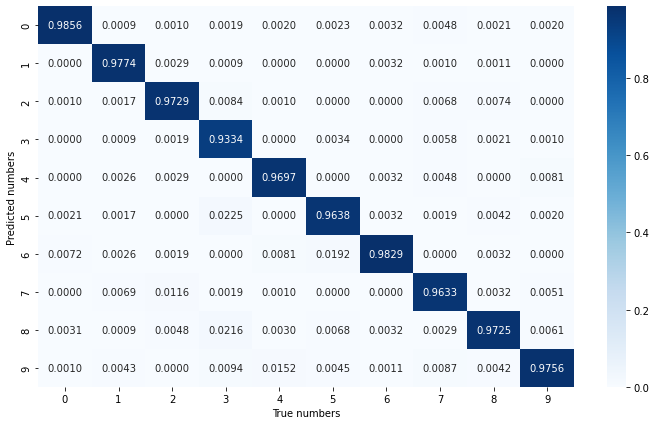

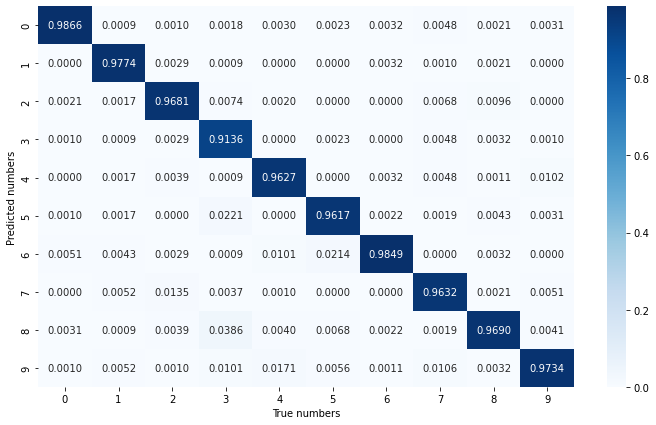

In [18]:
# Change batch size of test_loader to 1, to apply different noise for each individual image instead of batch
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(), BinaryTransform()
                             ])),
  batch_size=1, shuffle=True)

# Define PCM function
def PCM(w_in):
    # Define PCM allowed states and half allowed states for bucketizing
    PCM_Table = torch.tensor([0.87214, 1.01119, 1.19862, 1.44708, 1.71989, 1.98474, 2.27728, 2.57417, 2.86937, 3.07524, 3.44919, 3.78588, 4.12586, 4.46071, 4.75648, 5.10851]).to(device) 
    PCM_Table = PCM_Table - torch.min(PCM_Table)
    PCM_Table = PCM_Table*(torch.max(w_in)/torch.max(PCM_Table))
    #PCM_Table_negative = torch.flip(-PCM_Table[1:] ,[0])
    #PCM_Table = torch.cat((PCM_Table_negative, PCM_Table), 0)
    #print(PCM_Table)
    #PCM_Table = torch.flip(PCM_Table,[0])
    PCM_Table_2 = torch.zeros(2*len(PCM_Table)-1).to(device)
    
    # Generate PCM Buckets
    for i in range(0, len(PCM_Table)-1):
        PCM_Table_2[2*i] = PCM_Table[i]
        PCM_Table_2[2*i+1] = 0.5*(PCM_Table[i] + PCM_Table[i+1])
    PCM_Table_2[-1] = PCM_Table[-1]
    
    # Scale for a certain kernel and apply PCM discretization
    w_out = PCM_Table[torch.floor(torch.bucketize(w_in, PCM_Table_2)/2).long()]
    noise_var = 0.004*w_out
    noise_w = (noise_var**0.5)*torch.randn(list(w_in.size())).to(device)
    #print(w_out.shape)
    #print(noise_w.shape)
    return w_out, w_out + noise_w

#Save a backup
net2_conv1 = torch.clone(net2.conv1.weight)  
net2_conv2 = torch.clone(net2.conv2.weight)

#Apply PCM discretization to all the network layers
net2_conv1_PCM, net2_conv1_PCM_noisy = PCM(net2.conv1.weight) #Discretize or Discretize + noise
net2_conv1_PCM = nn.Parameter(net2_conv1_PCM)
#net2_conv1_PCM_noisy = nn.Parameter(net2_conv1_PCM_noisy)

net2_conv2_PCM, net2_conv2_PCM_noisy = PCM(net2.conv2.weight) #Discretize or Discretize + noise
net2_conv2_PCM = nn.Parameter(net2_conv2_PCM)
#net2_conv2_PCM_noisy = nn.Parameter(net2_conv2_PCM_noisy)

# Inject that into the network and test
print("Inference accuracy with PCM 4-bit accuracy + only Conv layers on PCM")
net2.conv1.weight = net2_conv1_PCM
net2.conv2.weight = net2_conv2_PCM
acc, y_true, y_pred = test(model = net2, test_loader = test_loader)
confusion(y_true, y_pred)

# Inject that into the network and test
print("Inference accuracy with PCM 4-bit accuracy + 0.4% Noise variance + only Conv layers on PCM")
net2.conv1.weight = net2_conv1_PCM
net2.conv2.weight = net2_conv2_PCM
#net2.conv1.weight = net2_conv1_PCM_noisy
#net2.conv2.weight = net2_conv2_PCM_noisy
acc_Hybrid_noise, y_true, y_pred = test(model = net2, test_loader = test_loader, noise_conv = 1)
confusion(y_true, y_pred)

#Check new Kernels
#print(net2.conv1.weight)
#print(net2.conv2.weight)

# Upload All layers on PTC (4-bits) and test

Inference accuracy with PCM 4-bit accuracy + all layers on PCM
Test Accuracy = 0.9462999701499939

Inference accuracy with PCM 4-bit accuracy + 0.4% Noise variance + all layers on PCM
Test Accuracy = 0.593999981880188



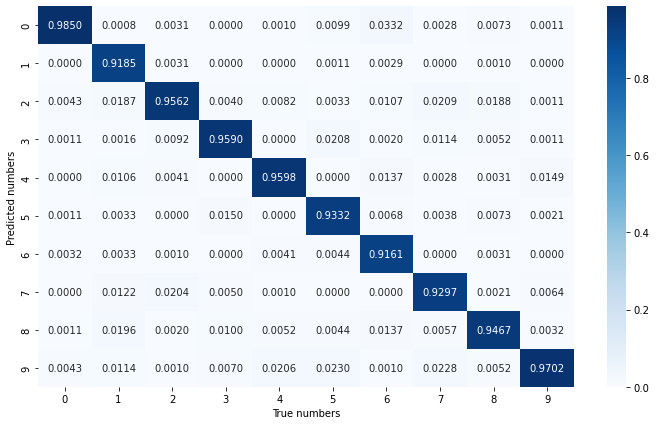

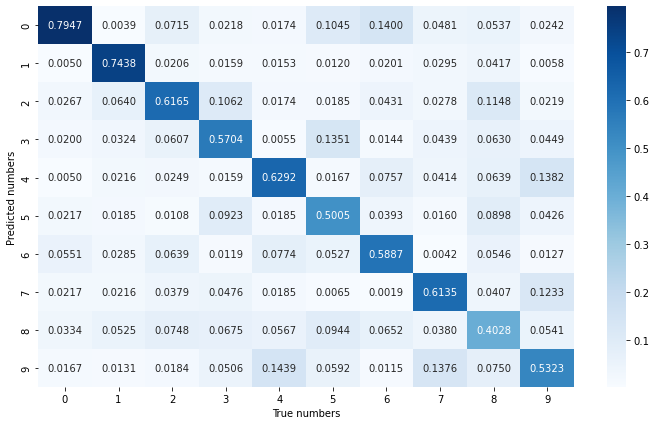

In [19]:
#Save a backup
net3_conv1 = torch.clone(net3.conv1.weight)  
net3_conv2 = torch.clone(net3.conv2.weight)
net3_fc1 = torch.clone(net3.fc1.weight)
net3_fc2 = torch.clone(net3.fc2.weight)

#Apply PCM discretization to all the network layers
net3_conv1_PCM, net3_conv1_PCM_noisy = PCM(net3.conv1.weight) #Discretize or Discretize + noise
net3_conv1_PCM = nn.Parameter(net3_conv1_PCM)
#net3_conv1_PCM_noisy = nn.Parameter(net3_conv1_PCM_noisy)

net3_conv2_PCM, net3_conv2_PCM_noisy = PCM(net3.conv2.weight) #Discretize or Discretize + noise
net3_conv2_PCM = nn.Parameter(net3_conv2_PCM)
#net3_conv2_PCM_noisy = nn.Parameter(net3_conv2_PCM_noisy)

net3_fc1_PCM, net3_fc1_PCM_noisy = PCM(net3.fc1.weight) #Discretize or Discretize + noise
net3_fc1_PCM = nn.Parameter(net3_fc1_PCM)
#net3_fc1_PCM_noisy = nn.Parameter(net3_fc1_PCM_noisy)

net3_fc2_PCM, net3_fc2_PCM_noisy = PCM(net3.fc2.weight) #Discretize or Discretize + noise
net3_fc2_PCM = nn.Parameter(net3_fc2_PCM)
#net3_fc2_PCM_noisy = nn.Parameter(net3_fc2_PCM_noisy)

# Inject that into the network and test
print("Inference accuracy with PCM 4-bit accuracy + all layers on PCM")
net3.conv1.weight = net3_conv1_PCM
net3.conv2.weight = net3_conv2_PCM
net3.fc1.weights = net3_fc1
net3.fc2.weights = net3_fc2
acc, y_true, y_pred = test(model = net3, test_loader = test_loader)
confusion(y_true, y_pred)

# Inject that into the network and test
print("Inference accuracy with PCM 4-bit accuracy + 0.4% Noise variance + all layers on PCM")
net3.conv1.weight = net3_conv1_PCM
net3.conv2.weight = net3_conv2_PCM
net3.fc1.weights = net3_fc1
net3.fc2.weights = net3_fc2
#net3.conv1.weight = net3_conv1_PCM_noisy
#net3.conv2.weight = net3_conv2_PCM_noisy
#net3.fc1.weight = net3_fc1_PCM_noisy
#net3.fc2.weight = net3_fc2_PCM_noisy
acc_PTC_noise, y_true, y_pred = test(model = net3, test_loader = test_loader, noise_conv = 1, noise_fc = 1)
confusion(y_true, y_pred)

#Check new Kernels
#print(net2.conv1.weight)
#print(net2.conv2.weight)

# FOM calculation

### Network 1 = All on GPU

##### Timing functions

In [20]:
# Time model on GPU
def time_GPU(model, dummy_input):
    # INIT LOGGERS
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    repetitions = 1000
    timings=np.zeros((repetitions,1))

    #GPU-WARM-UP
    for _ in range(10):
        _ = model(dummy_input)

    # MEASURE PERFORMANCE
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = model(dummy_input)
            ender.record()
            # WAIT FOR GPU SYNC
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_time = np.sum(timings) / repetitions
    std_time = np.std(timings)
    return mean_time

# Time a function on CPU
#from time import process_time
import time
def time_CPU(f, repetitions = 1000):
    timings=np.zeros((repetitions,1))
    
    for rep in range(repetitions):
        start = time.time()
        f()
        end = time.time()
        curr_time = end-start
        
        timings[rep] = curr_time
        
    mean_time = np.sum(timings) / repetitions
    std_time = np.std(timings)
    return mean_time

# Test the CPU function
def f():
    time.sleep(0.5)
t = time_CPU(f, 10)
print(t)

def f():
    return
t = time_CPU(f)
print(t)

0.5104421138763428
0.0


##### Calculate time/energy for the network as a whole

In [21]:
################### Network1 accuracy ###################
Accuracy_net1 = acc_GPU
print("Network1 accuracy = ", Accuracy_net1)

################### Network1 time per inference ###################
model = net1
dummy_input = torch.rand(1, 1, 28, 28, dtype=torch.float).to(device)

time_net1 = time_GPU(model, dummy_input)
print("Network1 average inference time (s) = ", time_net1)

################### Network1 energy per inference ###################
P_GPU = 120 #GTX 1660Ti wattage
energy_net1 = P_GPU*time_net1
print("Network1 energy per inference (J) = ", energy_net1)

Network1 accuracy =  tensor(0.9849, device='cuda:0')
Network1 average inference time (s) =  0.04897436803206801
Network1 energy per inference (J) =  5.8769241638481615


##### Calculate time for each part of the broken-down network - Method 1

In [22]:
#Define subnetworks
class CNN_conv1(nn.Module):
    def __init__(self, input_size, n_feature):
        super(CNN_conv1, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        return x
    
class CNN_ReLU(nn.Module):
    def __init__(self):
        super(CNN_ReLU, self).__init__()
        
    def forward(self, x, verbose=False):
        x = F.relu(x)
        return x

class CNN_maxpool(nn.Module):
    def __init__(self):
        super(CNN_maxpool, self).__init__()
        
    def forward(self, x, verbose=False):
        x = F.max_pool2d(x, kernel_size=2)
        return x

class CNN_conv2(nn.Module):
    def __init__(self, n_feature):
        super(CNN_conv2, self).__init__()
        self.n_feature = n_feature
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        
    def forward(self, x, verbose=False):
        x = self.conv2(x)
        return x    
    
class CNN_FC(nn.Module):
    def __init__(self, n_feature, output_size):
        super(CNN_FC, self).__init__()
        self.n_feature = n_feature
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, output_size)
        
    def forward(self, x, verbose=False):
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

input_size  = 28*28   # images are 28x28 pixels
n_features = 6        # number of feature maps
output_size = 10      # there are 10 classes       

#Test subnetworks

#Conv1     
net_conv1 = CNN_conv1(input_size, n_features); net_conv1.to(device)
dummy_input = torch.rand(1, 1, 28, 28, dtype=torch.float).to(device)
time_conv1 = time_GPU(net_conv1, dummy_input)
energy_conv1 = P_GPU*time_conv1

print("Conv1 inference time (s) = ", time_conv1)
print("Conv1 energy per inference (J) = ", energy_conv1)
print("#########################################################")

#ReLU1     
net_ReLU1 = CNN_ReLU(); net_ReLU1.to(device)
dummy_input = torch.rand(1, 6, 24, 24, dtype=torch.float).to(device)
time_ReLU1 = time_GPU(net_ReLU1, dummy_input)
energy_ReLU1 = P_GPU*time_ReLU1

print("ReLU1 inference time (s) = ", time_ReLU1)
print("ReLU1 energy per inference (J) = ", energy_ReLU1)
print("#########################################################")

#maxpool1     
net_maxpool1 = CNN_maxpool(); net_maxpool1.to(device)
dummy_input = torch.rand(1, 6, 24, 24, dtype=torch.float).to(device)
time_maxpool1 = time_GPU(net_maxpool1, dummy_input)
energy_maxpool1 = P_GPU*time_maxpool1

print("Maxpool1 inference time (s) = ", time_maxpool1)
print("Maxpool1 energy per inference (J) = ", energy_maxpool1)
print("#########################################################")

#Conv2     
net_conv2 = CNN_conv2(n_features); net_conv2.to(device)
dummy_input = torch.rand(1, 6, 12, 12, dtype=torch.float).to(device)
time_conv2 = time_GPU(net_conv2, dummy_input)
energy_conv2 = P_GPU*time_conv2

print("Conv2 inference time (s) = ", time_conv2)
print("Conv2 energy per inference (J) = ", energy_conv2)
print("#########################################################")

#ReLU2     
net_ReLU2 = CNN_ReLU(); net_ReLU2.to(device)
dummy_input = torch.rand(1, 6, 8, 8, dtype=torch.float).to(device)
time_ReLU2 = time_GPU(net_ReLU2, dummy_input)
energy_ReLU2 = P_GPU*time_ReLU2

print("ReLU2 inference time (s) = ", time_ReLU2)
print("ReLU2 energy per inference (J) = ", energy_ReLU2)
print("#########################################################")

#maxpool2     
net_maxpool2 = CNN_maxpool(); net_maxpool2.to(device)
dummy_input = torch.rand(1, 6, 8, 8, dtype=torch.float).to(device)
time_maxpool2 = time_GPU(net_maxpool2, dummy_input)
energy_maxpool2 = P_GPU*time_maxpool2

print("Maxpool2 inference time (s) = ", time_maxpool2)
print("Maxpool2 energy per inference (J) = ", energy_maxpool2)
print("#########################################################")

#FC     
net_FC = CNN_FC(n_features, output_size); net_FC.to(device)
dummy_input = torch.rand(1, 6, 4, 4, dtype=torch.float).to(device)
time_FC = time_GPU(net_FC, dummy_input)
energy_FC = P_GPU*time_FC

print("FC inference time (s) = ", time_FC)
print("FC energy per inference (J) = ", energy_FC)
print("#########################################################")

#Total
total_time = time_conv1 + time_ReLU1 + time_maxpool1 + time_conv2 + time_ReLU2 + time_maxpool2 + time_FC
total_energy = energy_conv1 + energy_ReLU1 + energy_maxpool1 + energy_conv2 + energy_ReLU2 + energy_maxpool2 + energy_FC

print("Total inference time (s) = ", total_time)
print("Total energy per inference (J) = ", total_energy)

Conv1 inference time (s) =  0.010747103963047266
Conv1 energy per inference (J) =  1.289652475565672
#########################################################
ReLU1 inference time (s) =  0.003982688052579761
ReLU1 energy per inference (J) =  0.4779225663095713
#########################################################
Maxpool1 inference time (s) =  0.0047175359912216665
Maxpool1 energy per inference (J) =  0.5661043189466
#########################################################
Conv2 inference time (s) =  0.016969504170119762
Conv2 energy per inference (J) =  2.0363405004143713
#########################################################
ReLU2 inference time (s) =  0.003986112049547955
ReLU2 energy per inference (J) =  0.4783334459457546
#########################################################
Maxpool2 inference time (s) =  0.0045712640024721625
Maxpool2 energy per inference (J) =  0.5485516802966595
#########################################################
FC inference time (s) =  0.014

##### Re-profile conv1 and conv2 but without adding bias, to be able to compare to photonic convolution (that has no bias)

In [47]:
class CNN_conv1(nn.Module):
    def __init__(self, input_size, n_feature):
        super(CNN_conv1, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5, bias=False)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        return x

class CNN_conv2(nn.Module):
    def __init__(self, n_feature):
        super(CNN_conv2, self).__init__()
        self.n_feature = n_feature
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5, bias=False)
        
    def forward(self, x, verbose=False):
        x = self.conv2(x)
        return x   
    
#Conv1     
net_conv1 = CNN_conv1(input_size, n_features); net_conv1.to(device)
dummy_input = torch.rand(1, 1, 28, 28, dtype=torch.float).to(device)
time_conv1 = time_GPU(net_conv1, dummy_input)
energy_conv1 = P_GPU*time_conv1

print("Conv1 (no bias) inference time (s) = ", time_conv1)
print("Conv1 (no bias) energy per inference (J) = ", energy_conv1)
print("#########################################################")    
    
#Conv2     
net_conv2 = CNN_conv2(n_features); net_conv2.to(device)
dummy_input = torch.rand(1, 6, 12, 12, dtype=torch.float).to(device)
time_conv2 = time_GPU(net_conv2, dummy_input)
energy_conv2 = P_GPU*time_conv2

print("Conv2 (no bias) inference time (s) = ", time_conv2)
print("Conv2 (no bias) energy per inference (J) = ", energy_conv2)
print("#########################################################")

Conv1 (no bias) inference time (s) =  0.007630144016817212
Conv1 (no bias) energy per inference (J) =  0.9156172820180655
#########################################################
Conv2 (no bias) inference time (s) =  0.013875551947392524
Conv2 (no bias) energy per inference (J) =  1.665066233687103
#########################################################


##### Calculate time for each part of the broken-down network - Method 2, just to check quickly method 1. Run multiple times as this is not averaged, and average a few runs yourself

In [48]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
curr_time = np.zeros(7)

class CNN_measure(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_measure, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        #torch.cuda.empty_cache()
        starter.record()
        x = self.conv1(x)
        ender.record()
        torch.cuda.synchronize()
        curr_time[0] = starter.elapsed_time(ender)
        #print(curr_time[0])
        
        #torch.cuda.empty_cache()
        starter.record()
        x = F.relu(x)
        ender.record()
        torch.cuda.synchronize()
        curr_time[1] = starter.elapsed_time(ender)
        #print(curr_time[1])
        
        #torch.cuda.empty_cache()
        starter.record()
        x = F.max_pool2d(x, kernel_size=2)
        ender.record()
        torch.cuda.synchronize()
        curr_time[2] = starter.elapsed_time(ender)
        #print(curr_time[2])
        
        #torch.cuda.empty_cache()
        starter.record()
        x = self.conv2(x)
        ender.record()
        torch.cuda.synchronize()
        curr_time[3] = starter.elapsed_time(ender)
        #print(curr_time[3])
        
        #torch.cuda.empty_cache()
        starter.record()
        x = F.relu(x)
        ender.record()
        torch.cuda.synchronize()
        curr_time[4] = starter.elapsed_time(ender)
        #print(curr_time[4])
        
        #torch.cuda.empty_cache()
        starter.record()
        x = F.max_pool2d(x, kernel_size=2)
        ender.record()
        torch.cuda.synchronize()
        curr_time[5] = starter.elapsed_time(ender)
        #print(curr_time[5])
        
        #torch.cuda.empty_cache()
        starter.record()
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        ender.record()
        torch.cuda.synchronize()
        curr_time[6] = starter.elapsed_time(ender)
        #print(curr_time[6])
        return x
    
input_size  = 28*28   # images are 28x28 pixels
n_features = 6        # number of feature maps
output_size = 10      # there are 10 classes        

net_1 = CNN_measure(input_size, n_features, output_size); net_1.to(device);
dummy_input = torch.rand(1, 1, 28, 28, dtype=torch.float).to(device)
_ = net_1(dummy_input)

print("Total inference time (s)  = ", np.sum(curr_time))
print("Total energy per inference (J)  = ", np.sum(curr_time)*P_GPU)

Total inference time (s)  =  0.05865600076504052
Total energy per inference (J)  =  7.038720091804862


### Network 2 = Conv layers on PTC, FC layers on GPU

##### conv1 layer without ReLU

In [54]:
#### Assuming the image is on PC >> Time/Power on CPU to divide the image to 3x1 vectors
# time to break images to 3x1 portions. We assume the kernel is always readily broken to 3x1 vectors as it is fixed
Image_pixel = np.random.rand(24, 24, 5, 5)
Image_pixel_padded = np.zeros((24, 24, 27)) #Padded to 27 to be divisible by 3
Image_pixel_reshaped = np.zeros((24, 24, 9, 3))

def f():
    Image_pixel_padded[:, :, 0:25] = Image_pixel.reshape(24, 24, 25)
    Image_pixel_reshaped = Image_pixel_padded.reshape(24, 24, 9, 3)
    
time_break_all_image = time_CPU(f, 100000) #time to prepare multiplications to upload on PTC 

P_CPU = 45 #I7-7950H wattage
energy_break_all_image = P_CPU*time_break_all_image

print("time_break_all_image = ", time_break_all_image)
print("energy_break_all_image = ", energy_break_all_image)

#### time/power on PTC
# DAC time/power so that we can upload to PTC. PTC has three channels each does 3x1 X 3x1 dot product. Each channel has its DAC, ADC and PD
DAC_speed = 20e9 #in Hz
time_three_dot_porduct_DAC = 1/DAC_speed

P_DAC = 0.035 #ADC wattage
P_three_dot_porduct_DAC = P_DAC*time_three_dot_porduct_DAC

# Time/power PTC = photodetector time + modulator time (our limit)
PD_speed = 20e9 #in Hz
time_three_dot_porduct_PD = 1/PD_speed 

P_TIA = 0.864 #TIA wattage
P_three_dot_porduct_PD = P_TIA*time_three_dot_porduct_PD

Mod_speed = 20e9 #in Hz
time_three_dot_porduct_Mod = 1/Mod_speed

P_Mod = 0.0102
P_three_dot_porduct_Mod = P_Mod*time_three_dot_porduct_Mod

# ADC time/power so that we can upload to PC. PTC has three channels each does 3x1 X 3x1 dot product. Each channel has its ADC
ADC_speed = 20e9 #in Hz
time_three_dot_porduct_ADC = 1/ADC_speed

P_ADC = 0.034 #DAC wattage
P_three_dot_porduct_ADC = P_ADC*time_three_dot_porduct_ADC

# Total time for conv1 on PTC
n_3x1_vectors_per_pixel = 9 #25 is padded to 27, and 27/3 = 9

time_three_dot_product = time_three_dot_porduct_DAC + time_three_dot_porduct_PD + time_three_dot_porduct_Mod + time_three_dot_porduct_ADC
time_PTC = time_three_dot_product*(n_3x1_vectors_per_pixel/3)*24*24*6   # /3 becuase we do 3 in parallel

P_laser = 6.28e-6 #laser wattage
energy_laser = P_laser*time_PTC

energy_three_dot_product = 9*P_three_dot_porduct_DAC + P_three_dot_porduct_PD + 9*P_three_dot_porduct_Mod + P_three_dot_porduct_ADC + 3*energy_laser
energy_PTC = energy_three_dot_product*n_3x1_vectors_per_pixel*24*24*6

print("time_PTC = ", time_PTC)
print("energy_PTC = ", energy_PTC)

#### Time/power on CPU to combine the output image. For each pixel, we add all PTC results (convolution process)
output_from_PTC_per_pixel = np.random.rand(24, 24, 6, n_3x1_vectors_per_pixel) #For each pixel, we add 9 scalar results of 3x1 dot products

def f():
    one_pixel_conv = np.sum(output_from_PTC_per_pixel, axis = 3) 

time_combine_all_image = time_CPU(f, 100000)  #time to prepare multiplications to upload on PTC
energy_combine_all_image = P_CPU*time_combine_all_image

print("time_combine_all_image = ", time_combine_all_image)
print("energy_combine_all_image = ", energy_combine_all_image)

#### Total time/power
# total time
time_conv1 = time_break_all_image + time_PTC + time_combine_all_image
print("Conv1 time per inference (s) = ", time_conv1)

# total power
energy_conv1 = energy_break_all_image + energy_PTC + energy_combine_all_image
print("Conv1 energy per inference (J) = ", energy_conv1)

time_break_all_image =  1.2180874347686768e-05
energy_break_all_image =  0.0005481393456459046
time_PTC =  2.0736e-06
energy_PTC =  3.2443532328959995e-06
time_combine_all_image =  4.6497154235839844e-05
energy_combine_all_image =  0.002092371940612793
Conv1 time per inference (s) =  6.0751628583526614e-05
Conv1 energy per inference (J) =  0.0026437556394915936


##### Add bias to conv 1 + ReLU + Pooling after conv1

In [55]:
#### Define this small network
class ReLU_Pool_conv1(nn.Module):
    def __init__(self, input_size):
        super(ReLU_Pool_conv1, self).__init__()
        
    def forward(self, x, verbose=False):
        x = x + 5
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        return x
    
input_size  = 24*24   # feature maps are 28x28 pixels      
net_ReLU_Pool_conv1 = ReLU_Pool_conv1(input_size); net_ReLU_Pool_conv1.to(device)

####get time/power
#Time
model = net_ReLU_Pool_conv1
dummy_input = torch.rand(1, 6, 24, 24, dtype=torch.float).to(device)
        
time_net_ReLU_Pool_conv1 = time_GPU(model, dummy_input)

print("ReLU_Pool_conv1 inference time (s) = ", time_net_ReLU_Pool_conv1)

#Power
energy_net_ReLU_Pool_conv1 = P_GPU*time_net_ReLU_Pool_conv1
print("ReLU_Pool_conv1 energy per inference (J) = ", energy_net_ReLU_Pool_conv1)

ReLU_Pool_conv1 inference time (s) =  0.008353791947476565
ReLU_Pool_conv1 energy per inference (J) =  1.0024550336971878


##### conv2 layer without ReLU

In [58]:
#### Time/Power on CPU to divide 6 feature maps (each 8x8) to 3x1 vectors
# time to break images to 3x1 portions. We assume the kernel is always readily broken to 3x1 vectors as it is fixed
Image_pixel = np.random.rand(8, 8, 6, 5, 5)     #Image here is the feature map
Image_pixel_padded = np.zeros((8, 8, 6, 27)) #Padded to 27 to be divisible by 3
Image_pixel_reshaped = np.zeros((8, 8, 6, 9, 3))

def f():
    Image_pixel_padded[:, :, :, 0:25] = Image_pixel.reshape(8, 8, 6, 25)
    Image_pixel_reshaped = Image_pixel_padded.reshape(8, 8, 6, 9, 3)
    
time_break_all_image = time_CPU(f, 100000) #time to prepare multiplications to upload on PTC

print("time_break_all_image = ", time_break_all_image)
print("energy_break_all_image = ", energy_break_all_image)

energy_break_all_image = P_CPU*time_break_all_image

#### time/power on PTC
time_three_dot_product = time_three_dot_porduct_DAC + time_three_dot_porduct_PD + time_three_dot_porduct_Mod + time_three_dot_porduct_ADC
time_PTC = time_three_dot_product*(n_3x1_vectors_per_pixel/3)*8*8*6*6   # /3 becuase we do 3 in parallel

energy_laser = P_laser*time_PTC

energy_three_dot_product = 9*P_three_dot_porduct_DAC + P_three_dot_porduct_PD + 9*P_three_dot_porduct_Mod + P_three_dot_porduct_ADC + 3*energy_laser
energy_PTC = energy_three_dot_product*n_3x1_vectors_per_pixel*8*8*6*6

print("time_PTC = ", time_PTC)
print("energy_PTC = ", energy_PTC)

#### Time/power on CPU to combine the output image. For each pixel, we add all PTC results (convolution process)
output_from_PTC_per_pixel = np.random.rand(8, 8, 6, n_3x1_vectors_per_pixel) #For each pixel, we add 9 scalar results of 3x1 dot products

def f():
    one_pixel_conv = np.sum(output_from_PTC_per_pixel, axis = 3) 

time_combine_all_image = time_CPU(f, 100000)  #time to prepare multiplications to upload on PTC
energy_combine_all_image = P_CPU*time_combine_all_image

print("time_combine_all_image = ", time_combine_all_image)
print("energy_combine_all_image = ", energy_combine_all_image)

#### Total time/power
# total time
time_conv2 = time_break_all_image + time_PTC + time_combine_all_image
print("Conv2 time per inference (s) = ", time_conv2)

# total power
energy_conv2 = energy_break_all_image + energy_PTC + energy_combine_all_image
print("Conv2 energy per inference (J) = ", energy_conv2)

time_break_all_image =  8.679795265197755e-06
energy_break_all_image =  0.0003841294527053833
time_PTC =  1.3824e-06
energy_PTC =  1.8928736501760001e-06
time_combine_all_image =  9.5204496383667e-06
energy_combine_all_image =  0.00042842023372650147
Conv2 time per inference (s) =  1.9582644903564453e-05
Conv2 energy per inference (J) =  0.0008209038943105764


##### Add bias to conv 2 + ReLU + Pooling after conv2 + FC layers

In [59]:
#### Define this small network
class ReLU_Pool_conv2_FC(nn.Module):
    def __init__(self, input_size):
        super(ReLU_Pool_conv2_FC, self).__init__()
        self.fc1 = nn.Linear(6*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = x + 5
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 6*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
input_size  = 8*8   # feature maps are 28x28 pixels      
net_ReLU_Pool_conv2_FC = ReLU_Pool_conv2_FC(input_size); net_ReLU_Pool_conv2_FC.to(device)

####get time/power
#Time
model = net_ReLU_Pool_conv2_FC
dummy_input = torch.rand(1, 6, 8, 8, dtype=torch.float).to(device)

time_net_ReLU_Pool_conv2_FC = time_GPU(model, dummy_input)
print("ReLU_Pool_conv2_FC inference time (s) = ", time_net_ReLU_Pool_conv2_FC)

#Power
energy_net_ReLU_Pool_conv2_FC = P_GPU*time_net_ReLU_Pool_conv2_FC
print("ReLU_Pool_conv2_FC energy per inference (J) = ", energy_net_ReLU_Pool_conv2_FC)

ReLU_Pool_conv2_FC inference time (s) =  0.021230111796408893
ReLU_Pool_conv2_FC energy per inference (J) =  2.5476134155690673


#### Total time/power for network2

In [63]:
################### Network2 accuracy ###################
Accuracy_net2 = acc_Hybrid_noise
print("Network2 accuracy = ", Accuracy_net2)

################### Network2 time per inference ###################
time_net2 = time_conv1 + time_net_ReLU_Pool_conv1 + time_conv2 + time_net_ReLU_Pool_conv2_FC
print("Network2 inference time (s) = ", time_net2)


################### Network2 energy per inference ###################
energy_net2 = energy_conv1 + energy_net_ReLU_Pool_conv1 + energy_conv1 + energy_net_ReLU_Pool_conv2_FC
print("Network2 energy per inference (J) = ", energy_net2)

Network2 accuracy =  tensor(0.9656, device='cuda:0')
Network2 inference time (s) =  0.02966423801737255
Network2 energy per inference (J) =  3.5553559605452385


### Network 3 = All layers on PTC but ReLU and Pool on GPU

##### conv1 layer without ReLU, Add bias to conv 1 + ReLU + Pooling after conv1, conv2 layer without ReLU

In [64]:
#same as network2

#### Add bias to conv 2 + ReLU + Pooling after conv2 + flatten

In [65]:
#### Define this small network
class ReLU_Pool_conv2(nn.Module):
    def __init__(self, input_size):
        super(ReLU_Pool_conv2, self).__init__()
        
    def forward(self, x, verbose=False):
        x = x + 5
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 96)
        return x
    
input_size  = 8*8   # feature maps are 28x28 pixels      
net_ReLU_Pool_conv2 = ReLU_Pool_conv2(input_size); net_ReLU_Pool_conv2.to(device)

####get time/power
#Time
model = net_ReLU_Pool_conv2
dummy_input = torch.rand(1, 6, 8, 8, dtype=torch.float).to(device)
  
time_net_ReLU_Pool_conv2 = time_GPU(model, dummy_input)
print("ReLU_Pool_conv2 inference time (s) = ", time_net_ReLU_Pool_conv2)

#Power
energy_net_ReLU_Pool_conv2 = P_GPU*time_net_ReLU_Pool_conv2
print("ReLU_Pool_conv2 energy per inference (J) = ", energy_net_ReLU_Pool_conv2)

ReLU_Pool_conv2 inference time (s) =  0.008184831977356226
ReLU_Pool_conv2 energy per inference (J) =  0.982179837282747


#### FC1 layer

In [69]:
from GeMM_timing import PhotonicTensor

#### Assuming the image is on PC >> Time/Power on CPU to divide the image to 3x1 vectors
# time to break matrix multiplication to 3x1 X 3x1 operations
a = np.random.rand(50,96)  # mat A
b = np.random.rand(96,1)   # output from conv2 flatenning
PT = PhotonicTensor(a, b, matSize=(3,1))

def f():
    PT.DotProduct_break_time()
time_break_mat_mul = time_CPU(f)

P_CPU = 45 #I7-7950H wattage
energy_break_mat_mul = P_CPU*time_break_mat_mul

print("time_break_mat_mul = ", time_break_mat_mul)
print("energy_break_mat_mul = ", energy_break_mat_mul)

#### time/power on PTC
# Total time for conv1 on PTC
n_3x1_vectors_dot_product = PT.count()

time_three_dot_product = time_three_dot_porduct_DAC + time_three_dot_porduct_PD + time_three_dot_porduct_Mod + time_three_dot_porduct_ADC
time_PTC = time_three_dot_product*(n_3x1_vectors_dot_product/3)   # /3 becuase we do 3 in parallel

energy_three_dot_product = 9*P_three_dot_porduct_DAC + P_three_dot_porduct_PD + 9*P_three_dot_porduct_Mod + P_three_dot_porduct_ADC + 3*energy_laser
energy_PTC = energy_three_dot_product*n_3x1_vectors_dot_product

print("time_PTC = ", time_PTC)
print("energy_PTC = ", energy_PTC)

#### Time/power on CPU to combine the output into one column

def f():
    PT.DotProduct_combine_time()
time_combine_mat_mul = time_CPU(f)

energy_combine_mat_mul = P_CPU*time_combine_mat_mul

print("time_combine_mat_mul = ", time_combine_mat_mul)
print("energy_combine_mat_mul = ", energy_combine_mat_mul)

#### Total time/power
# total time
time_FC1 = time_break_mat_mul + time_PTC + time_combine_mat_mul
print("FC1 time per inference (s) = ", time_FC1)

# total power
energy_FC1 = energy_break_mat_mul + energy_PTC + energy_combine_mat_mul 
print("FC1 energy per inference (J) = ", energy_FC1)

time_break_mat_mul =  0.0011672322750091552
energy_break_mat_mul =  0.052525452375411986
time_PTC =  1.0880000000000001e-07
energy_PTC =  1.4897616691200002e-07
time_combine_mat_mul =  0.005663994789123535
energy_combine_mat_mul =  0.2548797655105591
FC1 time per inference (s) =  0.00683133586413269
FC1 energy per inference (J) =  0.307405366862138


#### Add bias to FC1 then ReLU it

In [70]:
#### Define this small network
class ReLU_FC1(nn.Module):
    def __init__(self, input_size):
        super(ReLU_FC1, self).__init__()
        
    def forward(self, x, verbose=False):
        x = x + 5
        x = F.log_softmax(x, dim=1)
        return x
    
input_size  = 10   # feature maps are 28x28 pixels      
net_ReLU_FC1 = ReLU_FC1(input_size); net_ReLU_FC1.to(device)

####get time/power
#Time
model = net_ReLU_FC1
dummy_input = torch.rand(1, 10, dtype=torch.float).to(device)
        
time_net_ReLU_FC1 = time_GPU(model, dummy_input)
print("ReLU_FC1 inference time (s) = ", time_net_ReLU_FC1)

#Power
energy_net_ReLU_FC1 = P_GPU*time_net_ReLU_FC1
print("ReLU_FC1 energy per inference (J) = ", energy_net_ReLU_FC1)

ReLU_FC1 inference time (s) =  0.005841600053943694
ReLU_FC1 energy per inference (J) =  0.7009920064732432


#### FC2 layer

In [72]:
from time import process_time
from GeMM_timing import PhotonicTensor

#### Assuming the image is on PC >> Time/Power on CPU to divide the image to 3x1 vectors
# time to break matrix multiplication to 3x1 X 3x1 operations
a = np.random.rand(10,50)  # mat A
b = np.random.rand(50,1)   # output from FC1_ReLU
PT = PhotonicTensor(a, b, matSize=(3,1))

def f():
    PT.DotProduct_break_time()
time_break_mat_mul = time_CPU(f)

P_CPU = 45 #I7-7950H wattage
energy_break_mat_mul = P_CPU*time_break_mat_mul

print("time_break_mat_mul = ", time_break_mat_mul)
print("energy_break_mat_mul = ", energy_break_mat_mul)

#### time/power on PTC
# Total time for conv1 on PTC
n_3x1_vectors_dot_product = PT.count()

time_three_dot_product = time_three_dot_porduct_DAC + time_three_dot_porduct_PD + time_three_dot_porduct_Mod + time_three_dot_porduct_ADC
time_PTC = time_three_dot_product*(n_3x1_vectors_dot_product/3)   # /3 becuase we do 3 in parallel

energy_three_dot_product = 9*P_three_dot_porduct_DAC + P_three_dot_porduct_PD + 9*P_three_dot_porduct_Mod + P_three_dot_porduct_ADC + 3*energy_laser
energy_PTC = energy_three_dot_product*n_3x1_vectors_dot_product

print("time_PTC = ", time_PTC)
print("energy_PTC = ", energy_PTC)

#### Time/power on CPU to combine the output into one column

def f():
    PT.DotProduct_combine_time()
time_combine_mat_mul = time_CPU(f)

energy_combine_mat_mul = P_CPU*time_combine_mat_mul

print("time_combine_mat_mul = ", time_combine_mat_mul)
print("energy_combine_mat_mul = ", energy_combine_mat_mul)

#### Total time/power
# total time
time_FC2 = time_break_mat_mul + time_PTC + time_combine_mat_mul
print("FC2 time per inference (s) = ", time_FC2)

# total power
energy_FC2 = energy_break_mat_mul + energy_PTC + energy_combine_mat_mul
print("FC2 energy per inference (J) = ", energy_FC2)

time_break_mat_mul =  0.00016503500938415527
energy_break_mat_mul =  0.007426575422286987
time_PTC =  1.3333333333333335e-08
energy_PTC =  1.8256883200000002e-08
time_combine_mat_mul =  0.0006859633922576905
energy_combine_mat_mul =  0.03086835265159607
FC2 time per inference (s) =  0.0008510117349751791
FC2 energy per inference (J) =  0.03829494633076626


#### Add bias to FC2 then Sigmoid it

In [74]:
#### Define this small network
class Sigmoid_FC2(nn.Module):
    def __init__(self, input_size):
        super(Sigmoid_FC2, self).__init__()
        
    def forward(self, x, verbose=False):
        x = x + 5
        x = F.log_softmax(x, dim=1)
        return x
    
input_size  = 10   # feature maps are 28x28 pixels      
net_sigmoid_FC2 = Sigmoid_FC2(input_size); net_sigmoid_FC2.to(device)

####get time/power
#Time
model = net_sigmoid_FC2
dummy_input = torch.rand(1, 10, dtype=torch.float).to(device)

time_net_Sigmoid_FC2 = time_GPU(model, dummy_input)
print("Sigmoid_FC2 inference time (s) = ", time_net_Sigmoid_FC2)

#Power
energy_net_Sigmoid_FC2 = P_GPU*time_net_Sigmoid_FC2
print("Sigmoid_FC2 energy per inference (J) = ", energy_net_Sigmoid_FC2)

Sigmoid_FC2 inference time (s) =  0.005846240060403943
Sigmoid_FC2 energy per inference (J) =  0.7015488072484731


#### Total time/power for network3

In [75]:
################### Network3 accuracy ###################
Accuracy_net3 = acc_PTC_noise
print("Network3 accuracy = ", Accuracy_net3)

################### Network3 time per inference ###################
time_net3 = time_conv1 + time_net_ReLU_Pool_conv1 + time_conv2 + time_net_ReLU_Pool_conv2 + time_FC1 + time_net_ReLU_FC1 + time_FC2 + time_net_Sigmoid_FC2
print("Network3 inference time (s) = ", time_net3)


################### Network3 energy per inference ###################
energy_net3 = energy_conv1 + energy_net_ReLU_Pool_conv1 + energy_conv2 + energy_net_ReLU_Pool_conv2 + energy_FC1 + energy_net_ReLU_FC1 + energy_FC2 + energy_net_Sigmoid_FC2
print("Network3 energy per inference (J) = ", energy_net3)

Network3 accuracy =  tensor(0.5940, device='cuda:0')
Network3 inference time (s) =  0.03598914591177539
Network3 energy per inference (J) =  3.7363406574283577


### Comparing all networks

Text(0, 0.5, 'FOM $(s^{-1}J^{-1}$)')

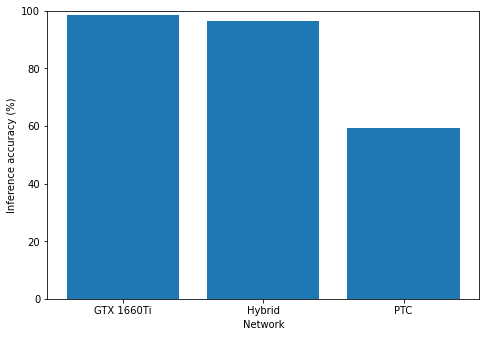

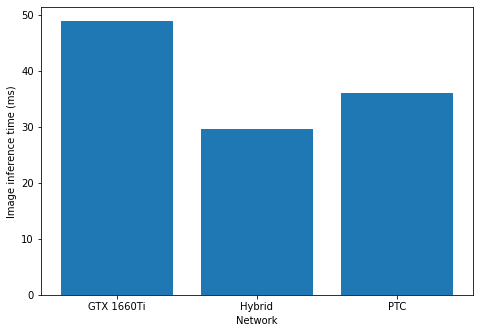

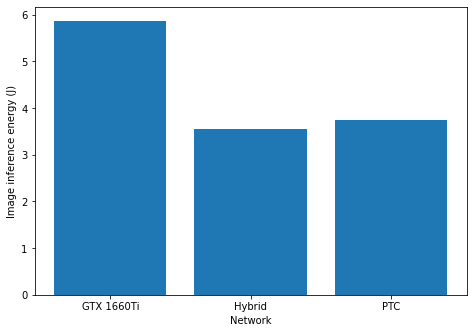

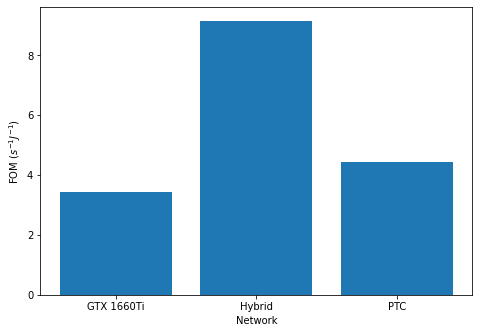

In [76]:
# Accuracy
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Network = ['GTX 1660Ti', 'Hybrid', 'PTC']
Accuracy = [Accuracy_net1.cpu()*100, Accuracy_net2.cpu()*100, Accuracy_net3.cpu()*100]
ax.bar(Network, Accuracy)
plt.ylim(0, 100)
plt.xlabel('Network')
plt.ylabel('Inference accuracy (%)')

# Time
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Network = ['GTX 1660Ti', 'Hybrid', 'PTC']
times = [time_net1*1000, time_net2*1000, time_net3*1000]
ax.bar(Network, times)
plt.xlabel('Network')
plt.ylabel('Image inference time (ms)')

# Energy
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Network = ['GTX 1660Ti', 'Hybrid', 'PTC']
energy = [energy_net1, energy_net2, energy_net3]
ax.bar(Network, energy)
plt.xlabel('Network')
plt.ylabel('Image inference energy (J)')

# FOM
FOM_net1 = Accuracy_net1.cpu()/(time_net1*energy_net1)
FOM_net2 = Accuracy_net2.cpu()/(time_net2*energy_net2)
FOM_net3 = Accuracy_net3.cpu()/(time_net3*energy_net3)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Network = ['GTX 1660Ti', 'Hybrid', 'PTC']
FOM = [FOM_net1, FOM_net2, FOM_net3]
ax.bar(Network, FOM)
plt.xlabel('Network')
plt.ylabel('FOM $(s^{-1}J^{-1}$)')